## &#x1F310; &nbsp; Code Library, Style, and Links
The previous notebooks:

&#x1F310; &nbsp; [PASSNYC. Data Exploration](https://www.kaggle.com/olgabelitskaya/passnyc-data-exploration)

&#x1F310; &nbsp; [PASSNYC. Numeric and Categorical Variables](https://www.kaggle.com/olgabelitskaya/passnyc-numeric-and-categorical-variables)

&#x1F310; &nbsp; [PASSNYC. Comparing All Districts with 5th District](passnyc-comparing-all-districts-with-5th-district)

&#x1F310; &nbsp; [PASSNYC. Regression Methods](https://www.kaggle.com/olgabelitskaya/passnyc-regression-methods)

&#x1F310; &nbsp; [PASSNYC. Neural Networks](https://www.kaggle.com/olgabelitskaya/passnyc-neural-networks)

&#x1F310; &nbsp; [PASSNYC. Neural Networks 2](https://www.kaggle.com/olgabelitskaya/passnyc-neural-networks-2)

Useful Links:

&#x1F310; &nbsp; [School Quality Reports. Educator Guide](http://schools.nyc.gov/NR/rdonlyres/967E0EE1-7E5D-4E47-BC21-573FEEE23AE2/0/201516EducatorGuideHS9252017.pdf)

In [1]:
%%html
<style> 
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: gainsboro;} 
a {color: #37c9e1; font-family: 'Roboto';} 
h1 {color: #37c9e1; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #aaa;} 
h2, h3 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #aaa;}
h4 {color: #37c9e1; font-family: 'Roboto';}
span {text-shadow: 4px 4px 4px #aaa;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #37c9e1;}      
div.output_stderr pre {background-color: gainsboro;}  
div.output_stderr {background-color: slategrey;}               
</style>

In [2]:
import numpy as np 
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from descartes import PolygonPatch

from IPython.display import HTML
from sklearn.preprocessing import minmax_scale

In [3]:
style_dict = {'background-color':'slategray',
              'color':'#37c9e1',
              'border-color':'white'}

## &#x1F310; &nbsp; Load and Preprocess the Data

In [45]:
school_explorer = pd.read_csv('2016 School Explorer.csv')
d5_shsat = pd.read_csv('D5 SHSAT Registrations and Testers.csv')
high_school = pd.read_csv('2016-doe-high-school-directory.csv')
safety = pd.read_csv('2010-2016-school-safety-report.csv')
school_explorer.shape, d5_shsat.shape, high_school.shape, safety.shape

((1272, 161), (140, 7), (437, 67), (6310, 34))

In [46]:
hsi = list(high_school.columns[[19,25,26,28,29,30,31,32]])
high_school.tail(3)[hsi].T.style.set_properties(**style_dict)

,434,435,436
website,www.aupnyc.org,http://schools.nyc.gov/SchoolPortals/32/K554,www.bushwickleaders.org
language_classes,Spanish,Spanish,Spanish
advancedplacement_courses,"Biology, Calculus, English, United States History",Statistics,"English, Spanish"
extracurricular_activities,"Advanced Art, African Dance, African Drumming, Annual “Day of Dialogue” Student-led Conference, Cheerleading, Community Service, Fine Arts, Hispanic Cultural Club, National Honor Society, Peer Mediation, Peer Tutoring, Student Government, Student Leadership Council, Student Newspaper, Video Game Club","Dance, School Newspaper, Marching Band, National Honor Society, Pre-Law/Debate; Students are expected to participate in the Memorial Day Parade as part of their leadership/service requirements in civic activities.","After-School Tutorial, Band, Chess, Chorus, Dance, Drama, Evening Classes, Math, Model United Nations, Odyssey of The Mind, Robotics, Saturday Academy, Spanish, Step, Student Government, Tennis, Visual Arts"
psal_sports_boys,"Baseball, Basketball, Soccer, Volleyball","Baseball, Basketball, Bowling, Handball, Volleyball",nan
psal_sports_girls,"Basketball, Softball, Volleyball","Basketball, Handball, Volleyball",nan
psal_sports_coed,nan,nan,nan
school_sports,"Baseball, Basketball, Flag Football, Volleyball, Weightlifting",nan,"Basketball, Baseball, Soccer, Volleyball, Handball"


In [47]:
pd.DataFrame(high_school.isna().sum()[high_school.isna().sum() !=0]\
             .sort_values(ascending=False))\
.head(25).style.set_properties(**style_dict)

,0
priority10,437
priority09,437
priority08,437
priority07,434
expgrade_span_min,420
expgrade_span_max,419
year_at_scale,419
priority06,418
priority05,399
partner_financial,356


In [48]:
safety.tail(3).T.style.set_properties(**style_dict)

,6307,6308,6309
School Year,2015-16,2015-16,2015-16
Building Code,X972,X973,X991
DBN,nan,12X271,79X695
Location Name,1440 STORY AVENUE CONSOLIDATED LOCATION,East Bronx Academy for the Future,Passages Academy
Location Code,nan,X271,X695
Address,1440 STORY AVENUE,1716 SOUTHERN BOULEVARD,560 BROOK AVENUE
Borough,X,X,X
Geographical District Code,8,12,7
Register,490,665,254
Building Name,1440 STORY AVENUE CONSOLIDATED LOCATION,nan,nan


In [49]:
pd.DataFrame(safety.isna().sum()[safety.isna().sum() !=0]\
             .sort_values(ascending=False))\
.head(25).style.set_properties(**style_dict)

,0
AvgOfMajor N,2757
AvgOfNoCrim N,2757
AvgOfOth N,2757
AvgOfVio N,2757
AvgOfProp N,2757
Major N,2749
Oth N,2749
NoCrim N,2749
Prop N,2749
Vio N,2749


In [50]:
# Fillna or replace values
numeric_list = list(school_explorer\
.columns[[7,8]+list(range(16,27))+[28,30,32,34,36]+list(range(41,161))])
target_list = ['Average ELA Proficiency','Average Math Proficiency']
crime_list = ['Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N']
result_list = ['Average ELA Proficiency','Average Math Proficiency']

school_explorer = school_explorer.drop(['Adjusted Grade',
                                        'New?',
                                        'Other Location Code in LCGMS'], 
                                       axis=1)
school_explorer.loc[[427,1023,712,908],'School Name'] = \
['P.S. 212 D12','P.S. 212 D30','P.S. 253 D21','P.S. 253 D27']

percent_list = ['Percent ELL','Percent Asian','Percent Black',
                'Percent Hispanic','Percent Black / Hispanic',
                'Percent White','Student Attendance Rate',
                'Percent of Students Chronically Absent',
                'Rigorous Instruction %','Collaborative Teachers %',
                'Supportive Environment %','Effective School Leadership %',
                'Strong Family-Community Ties %','Trust %']

for el in percent_list:
    school_explorer[el] = school_explorer[el].astype('str')
    school_explorer[el] = school_explorer[el].str.replace("%", "")
    school_explorer[el] = school_explorer[el].str.replace("nan", "0")
    school_explorer[el] = school_explorer[el].astype(float)
    school_explorer[el].replace(0, np.NaN, inplace=True)
    school_explorer[el] = school_explorer[el].interpolate()
    
school_explorer['Economic Need Index'] = \
school_explorer['Economic Need Index'].interpolate()
school_explorer['Average ELA Proficiency'] = \
school_explorer['Average ELA Proficiency'].interpolate()
school_explorer['Average Math Proficiency'] = \
school_explorer['Average Math Proficiency'].interpolate()

school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].astype('str') 
for s in [",","$"," "]:
    school_explorer['School Income Estimate'] = \
    school_explorer['School Income Estimate'].str.replace(s, "")
school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].str.replace("nan", "0")

school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].astype(float)
school_explorer['School Income Estimate'].replace(0, np.NaN, inplace=True)
school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].interpolate()

rating_list = ['Rigorous Instruction Rating','Collaborative Teachers Rating',
               'Supportive Environment Rating','Effective School Leadership Rating',
               'Strong Family-Community Ties Rating','Strong Family-Community Ties Rating',
               'Trust Rating','Student Achievement Rating']

for el in rating_list:
    moda_value = school_explorer[el].value_counts().idxmax()
    school_explorer[el] = school_explorer[el].fillna(moda_value) 
    
category_list1 = ['District','Community School?','City','Grades']
                  
category_list2 = ['Rigorous Instruction Rating',
                  'Collaborative Teachers Rating',
                  'Supportive Environment Rating',
                  'Effective School Leadership Rating',
                  'Strong Family-Community Ties Rating',
                  'Trust Rating','Student Achievement Rating']

for feature in category_list1:
    feature_cat = pd.factorize(school_explorer[feature])
    school_explorer[feature] = feature_cat[0]
    
for feature in category_list2:
    feature_pairs = dict(zip(['Not Meeting Target', 'Meeting Target', 
                              'Approaching Target', 'Exceeding Target'],
                             ['0','2','1','3']))
    school_explorer[feature].replace(feature_pairs,inplace=True)
    school_explorer[feature] = school_explorer[feature].astype(int)
    
category_list = list(category_list1+category_list2)
    
print('NaN count = ', sum(school_explorer.isna().sum()))    

NaN count =  0


In [51]:
# D5 Shools
d5_shsat.rename(columns={'DBN':'Location Code'}, inplace=True)
d5_shsat_2016 = \
d5_shsat[['Location Code','Number of students who registered for the SHSAT',
          'Number of students who took the SHSAT']][d5_shsat['Year of SHST']==2016]\
.groupby(['Location Code'],as_index=False).agg(np.sum)

d5_shsat_2016['Took SHSAT %'] = \
d5_shsat_2016['Number of students who took the SHSAT']\
/d5_shsat_2016['Number of students who registered for the SHSAT']

d5_shsat_2016['Took SHSAT %'] = \
d5_shsat_2016['Took SHSAT %'].fillna(0).apply(lambda x: round(x,3))

d5_shsat_2016 = pd.merge(school_explorer[['Location Code']+numeric_list+target_list],
                         d5_shsat_2016, 
                         on='Location Code')                       
d5_shsat_2016.shape

(21, 144)

In [52]:
# Districts' Data
geo_districts = gpd.GeoDataFrame.from_file("nysd.shp") # EPSG:2263
geo_districts = geo_districts.to_crs(epsg=4326).sort_values('SchoolDist')
geo_districts = geo_districts.reset_index(drop=True)

districts = \
school_explorer[numeric_list+['Average ELA Proficiency','Average Math Proficiency']]\
.groupby(school_explorer['District']).mean().sort_values('District')
districts = districts.append(districts.loc[9]).sort_values('District')
districts = districts.reset_index(drop=True)
districts = pd.concat([geo_districts, districts], axis=1)

districts.shape

(33, 144)

In [53]:
print(list(districts.columns[16:21]))

['Rigorous Instruction %', 'Collaborative Teachers %', 'Supportive Environment %', 'Effective School Leadership %', 'Strong Family-Community Ties %']


In [54]:
localcode_schoolexplorer_highschool = \
list(set(high_school['dbn']).intersection(set(school_explorer['Location Code'])))
localcode_d5shsat_highschool = \
list(set(high_school['dbn']).intersection(set(d5_shsat_2016['Location Code'])))

len(localcode_schoolexplorer_highschool), len(localcode_d5shsat_highschool)

(86, 4)

In [55]:
# high_school with school_explorer & d5_shsat_2016
high_school.rename(columns={'dbn':'Location Code'}, inplace=True)

schoolexplorer_highschool = \
pd.merge(school_explorer, high_school, on='Location Code')

d5shsat_highschool = \
pd.merge(d5_shsat_2016, high_school, on='Location Code')

schoolexplorer_highschool = \
schoolexplorer_highschool.drop(['Latitude_y','Longitude_y'], axis=1)
d5shsat_highschool = \
d5shsat_highschool.drop(['Latitude_y','Longitude_y'], axis=1)

schoolexplorer_highschool.shape, d5shsat_highschool.shape

((86, 222), (4, 208))

In [56]:
schoolexplorer_highschool.isna().sum()[schoolexplorer_highschool.isna().sum() !=0]

fax_number                     2
school_email                  12
grade_span_min                 3
expgrade_span_min             81
expgrade_span_max             80
year_at_scale                 80
subway                        17
campus_name                   72
school_type                   69
language_classes               5
advancedplacement_courses     25
diplomaendorsements           65
extracurricular_activities     1
psal_sports_boys              14
psal_sports_girls             18
psal_sports_coed              66
school_sports                 17
partner_cbo                   15
partner_hospital              48
partner_highered              15
partner_cultural              26
partner_nonprofit             23
partner_corporate             53
partner_financial             73
partner_other                 54
addtl_info1                   53
addtl_info2                    5
start_time                     3
end_time                       3
priority02                     1
priority03

In [57]:
d5shsat_highschool.isna().sum()[d5shsat_highschool.isna().sum() !=0]

school_email                  2
expgrade_span_min             3
expgrade_span_max             3
year_at_scale                 3
campus_name                   4
school_type                   3
language_classes              1
advancedplacement_courses     1
diplomaendorsements           3
extracurricular_activities    1
psal_sports_coed              3
school_sports                 2
partner_cbo                   2
partner_hospital              2
partner_highered              1
partner_cultural              2
partner_nonprofit             2
partner_corporate             2
partner_financial             3
partner_other                 4
addtl_info1                   4
start_time                    1
end_time                      1
priority03                    1
priority04                    2
priority05                    3
priority06                    3
priority07                    4
priority08                    4
priority09                    4
priority10                    4
dtype: i

In [58]:
hsl = high_school[['Location Code','language_classes']].dropna()
hsl['language_classes'] = hsl['language_classes'].apply(lambda x: x.split(', '))
hsl = hsl.reset_index(drop=True)

languages = []
for i in range(len(hsl)):
    l_list = list(set(hsl['language_classes'][i]))
    for l in l_list:
        if l not in languages:
            languages.append(l)

languages = sorted(languages)
for l in languages:
    hsl[l] = 0

for i in range(len(hsl)):
    for l in languages:
        if l in hsl['language_classes'][i]:
            hsl.loc[i,l] = 1
hsl = hsl.drop(['language_classes'], axis=1)
hsl['District'] = hsl['Location Code'].apply(lambda x: int(x[:2]))
                        
districts_hsl = hsl.groupby('District').sum()
districts_hsl.reset_index(level=0, inplace=True)

hsa = high_school[['Location Code','advancedplacement_courses']].dropna()
hsa['advancedplacement_courses'] = \
hsa['advancedplacement_courses'].apply(lambda x: x.split(', '))
hsa = hsa.reset_index(drop=True)

courses = []
for i in range(len(hsa)):
    a_list = list(set(hsa['advancedplacement_courses'][i]))
    for a in a_list:
        if a not in courses:
            courses.append(a)

courses = sorted(courses)
for a in courses:
    hsa[a] = 0

for i in range(len(hsa)):
    for a in courses:
        if a in hsa['advancedplacement_courses'][i]:
            hsa.loc[i,a] = 1
            

hsa = hsa.drop(['advancedplacement_courses','Latin','Spanish'], axis=1)
hsa['District'] = hsa['Location Code'].apply(lambda x: int(x[:2]))
                        
districts_hsa = hsa.groupby('District').sum()
districts_hsa.reset_index(level=0, inplace=True)

districts_hsl.shape, districts_hsa.shape

((32, 25), (32, 25))

In [76]:
sport_list = ['psal_sports_boys','psal_sports_girls','psal_sports_coed']

hss_boy = high_school[['Location Code',sport_list[0]]].dropna()
hss_girl = high_school[['Location Code',sport_list[1]]].dropna()
hss_coed = high_school[['Location Code',sport_list[2]]].dropna()

hss_boy[sport_list[0]] = hss_boy[sport_list[0]].apply(lambda x: x.split(', '))
hss_boy = hss_boy.reset_index(drop=True)
hss_girl[sport_list[1]] = hss_girl[sport_list[1]].apply(lambda x: x.split(', '))
hss_girl = hss_girl.reset_index(drop=True)
hss_coed[sport_list[2]] = hss_coed[sport_list[2]].apply(lambda x: x.split(', '))
hss_coed = hss_coed.reset_index(drop=True)

sports_boy = []
for i in range(len(hss_boy)):
    s_list = list(set(hss_boy[sport_list[0]][i]))
    for s in s_list:
        if s not in sports_boy:
            sports_boy.append(s)           
sports_girl = []
for i in range(len(hss_girl)):
    s_list = list(set(hss_girl[sport_list[1]][i]))
    for s in s_list:
        if s not in sports_girl:
            sports_girl.append(s)
sports_coed = []
for i in range(len(hss_coed)):
    s_list = list(set(hss_coed[sport_list[2]][i]))
    for s in s_list:
        if s not in sports_coed:
            sports_coed.append(s)
            
sports_boy = sorted(sports_boy)
for s in sports_boy:
    hss_boy[s+'_Boys'] = 0   
sports_girl = sorted(sports_girl)
for s in sports_girl:
    hss_girl[s+'_Girls'] = 0
sports_coed = sorted(sports_coed)
for s in sports_coed:
    hss_coed[s+'_Coed'] = 0

for i in range(len(hss_boy)):
    for s in sports_boy:
        if s in hss_boy[sport_list[0]][i]:
            hss_boy.loc[i,s+'_Boys'] = 1
for i in range(len(hss_girl)):
    for s in sports_girl:
        if s in hss_girl[sport_list[1]][i]:
            hss_girl.loc[i,s+'_Girls'] = 1
for i in range(len(hss_coed)):
    for s in sports_coed:
        if s in hss_coed[sport_list[2]][i]:
            hss_coed.loc[i,s+'_Coed'] = 1
            

hss_boy = hss_boy.drop([sport_list[0]], axis=1)
hss_girl = hss_girl.drop([sport_list[1]], axis=1)
hss_coed = hss_coed.drop([sport_list[2]], axis=1)

hss_boy['District'] = hss_boy['Location Code'].apply(lambda x: int(x[:2]))
hss_girl['District'] = hss_girl['Location Code'].apply(lambda x: int(x[:2]))
hss_coed['District'] = hss_coed['Location Code'].apply(lambda x: int(x[:2]))
    
districts_hss_boy = hss_boy.groupby('District').sum()
districts_hss_boy.reset_index(level=0, inplace=True)
districts_hss_girl = hss_girl.groupby('District').sum()
districts_hss_girl.reset_index(level=0, inplace=True)
districts_hss_coed = hss_coed.groupby('District').sum()
districts_hss_coed.reset_index(level=0, inplace=True)

districts_hss_boy.shape, districts_hss_girl.shape, districts_hss_coed.shape

((32, 20), (32, 22), (26, 12))

In [18]:
localcode_schoolexplorer_safety = \
list(set(safety['DBN']).intersection(set(school_explorer['Location Code'])))
localcode_d5shsat_safety = \
list(set(safety['DBN']).intersection(set(d5_shsat_2016['Location Code'])))

len(localcode_schoolexplorer_safety), len(localcode_d5shsat_safety)

(1146, 13)

In [19]:
safety.rename(columns={'Location Code':'Location Code 2'}, inplace=True)
safety.rename(columns={'DBN':'Location Code'}, inplace=True)

schoolexplorer_safety = safety[crime_list+['Location Code']].dropna()
schoolexplorer_safety = \
schoolexplorer_safety.groupby(['Location Code'], as_index=False)[crime_list].sum()
schoolexplorer_safety = \
pd.merge(school_explorer, schoolexplorer_safety, on='Location Code')


d5shsat_safety = safety[crime_list+['Location Code']].dropna()
d5shsat_safety = \
d5shsat_safety.groupby(['Location Code'], as_index=False)[crime_list].sum()
d5shsat_safety = \
pd.merge(d5_shsat_2016, d5shsat_safety, on='Location Code')

schoolexplorer_safety.shape, d5shsat_safety.shape

((719, 163), (7, 149))

In [20]:
schoolexplorer_safety.isna().sum()[schoolexplorer_safety.isna().sum() !=0]

Series([], dtype: int64)

In [21]:
d5shsat_safety.isna().sum()[d5shsat_safety.isna().sum() !=0]

Series([], dtype: int64)

In [22]:
districts_safety = \
schoolexplorer_safety[crime_list+['District']].dropna()
districts_safety = districts_safety.groupby(districts_safety['District'])\
.sum().sort_values('District')
districts_safety = districts_safety.append(districts_safety.loc[9]).sort_values('District')
districts_safety = districts_safety.reset_index(drop=True)
districts_safety = pd.concat([districts,districts_safety], axis=1)

districts_safety.shape

(33, 149)

## &#x1F310; &nbsp; Leaders in the 5th District
[PASSNYC. Comparing All Districts with 5th District](passnyc-comparing-all-districts-with-5th-district)

1) 05M362 [Columbia Secondary School](http://www.columbiasecondary.org/)

2) 84M336 [KIPP Infinity Charter School](https://www.kippnyc.org/)

3) 84M384 [Success Academy Charter School - Harlem 2](https://www.successacademies.org/)

In [23]:
def highlight(df):
    if df['Economic Need Index'] < 0.6:
        return ['background-color: red']
    elif df['Economic Need Index'] > 0.79:
        return ['background-color: blue']
    else:
        return ['background-color: orchid']
leaders5d = pd.DataFrame(d5_shsat_2016['Economic Need Index'].loc[[7,13,16]])
leaders5d = leaders5d.set_index([d5_shsat_2016['Location Code'].loc[[7,13,16]]])

leaders5d.style.apply(highlight, axis=1)

,Economic Need Index
Location Code,
05M362,0.507
84M336,0.798
84M384,0.734


## &#x1F310; &nbsp; Demographic Data Visualization
#### Ethnic characteristics

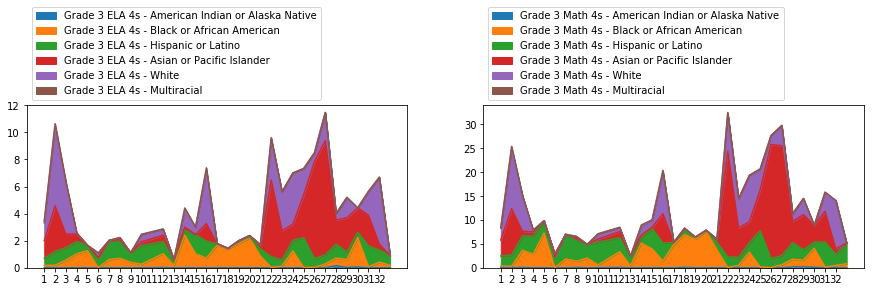

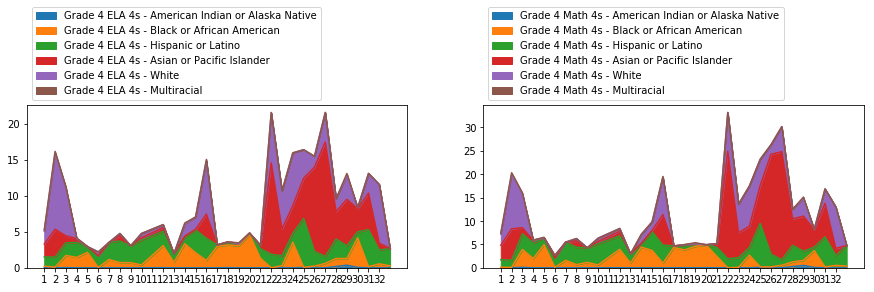

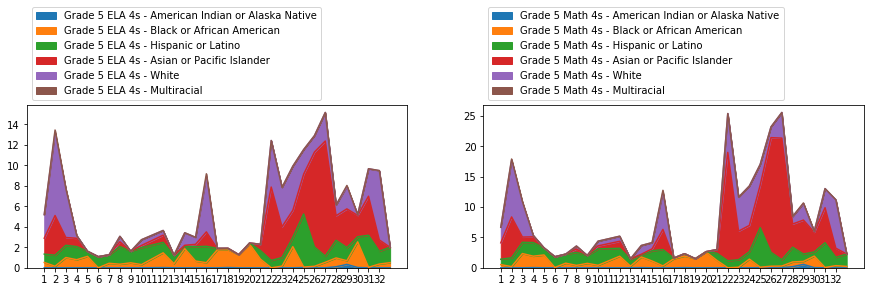

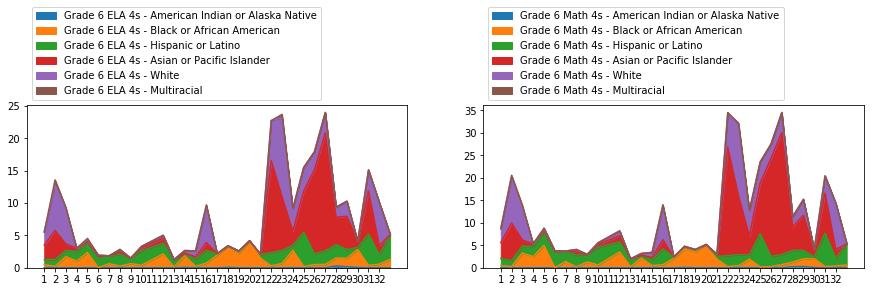

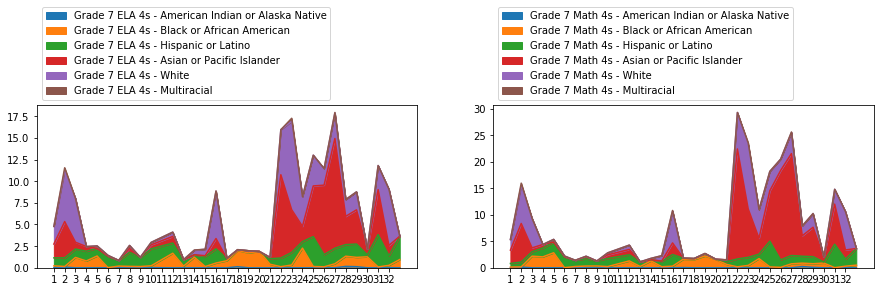

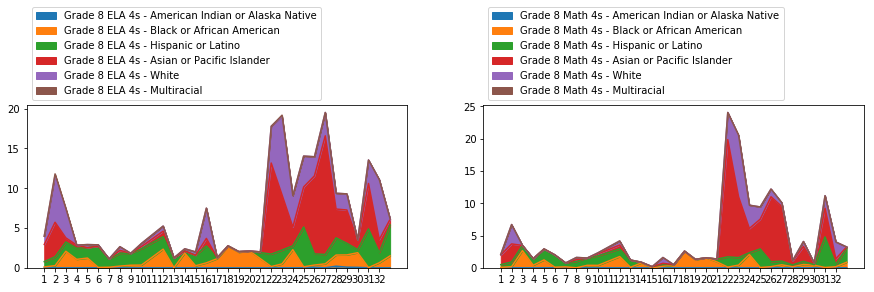

In [24]:
def districts_grade_4s(n):
    fig,ax = plt.subplots(ncols=2, figsize=(15,3))
    for i in [0,1]:
        col=[n+i*10,n+1+i*10,n+2+i*10,n+3+i*10,n+4+i*10,n+5+i*10]
        districts[districts.columns[col]].drop([10]).plot.area(ax=ax[i])
        ax[i].legend(loc=3, bbox_to_anchor=(0, 1))
        ax[i].set_xticks(list(range(0,32)))
        ax[i].set_xticklabels(list(range(1,33)));
        
for d in [24,44,64,84,104,124]:       
    districts_grade_4s(d)

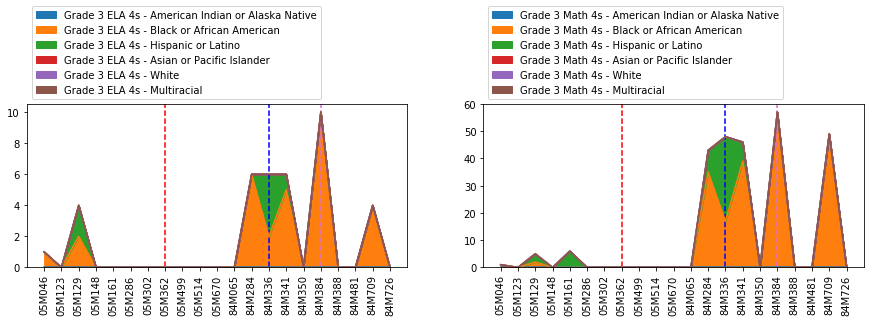

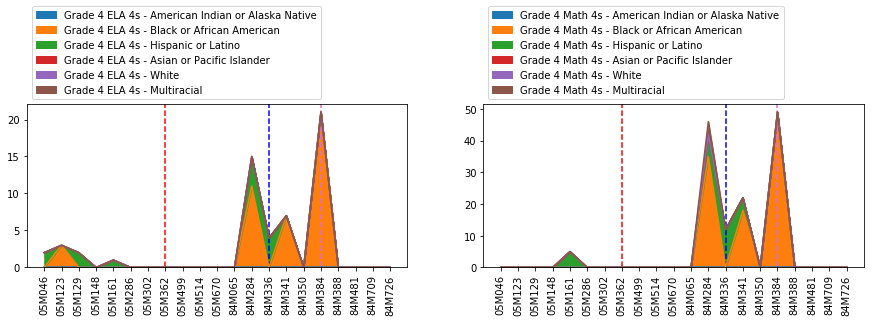

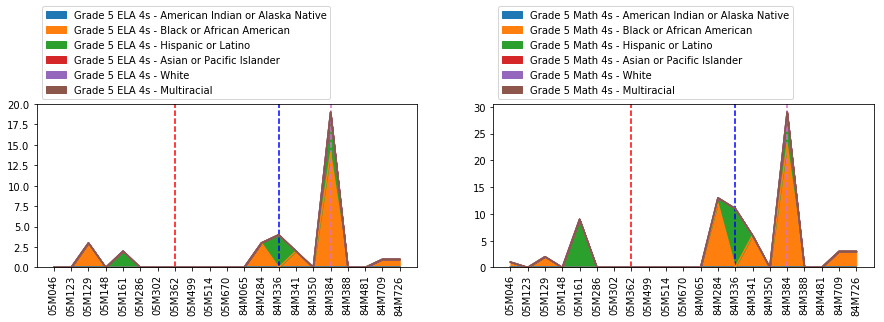

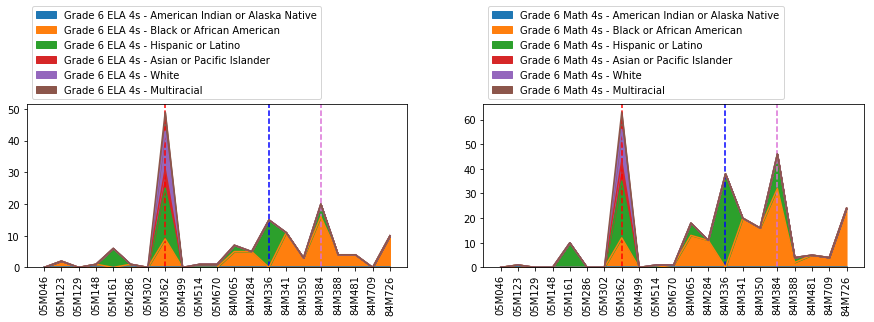

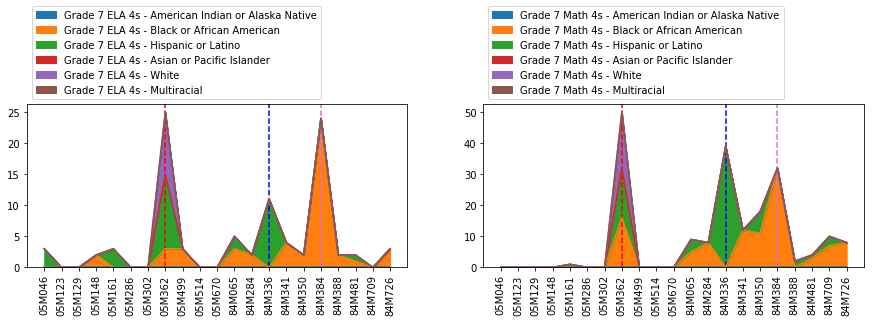

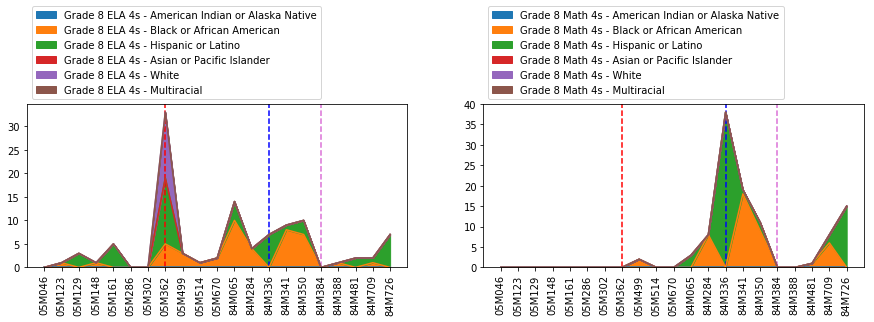

In [105]:
def district5_grade_4s(n):
    fig,ax = plt.subplots(ncols=2, figsize=(15,3))
    for i in [0,1]:
        col=[n+i*10,n+1+i*10,n+2+i*10,n+3+i*10,n+4+i*10,n+5+i*10]
        d5_shsat_2016[d5_shsat_2016.columns[col]].plot.area(ax=ax[i])
        ax[i].vlines(7,0,70,linestyle="--",color='red') 
        ax[i].vlines(13,0,70,linestyle="--",color='blue')
        ax[i].vlines(16,0,70,linestyle="--",color='orchid')
        ax[i].legend(loc=3, bbox_to_anchor=(0,1))
        ax[i].set_xticks(list(range(0,21)))
        ax[i].set_xticklabels(list(d5_shsat_2016['Location Code']),
                              rotation=90);
        
for d in [21,41,61,81,101,121]:       
    district5_grade_4s(d)

Three leaders among the schools from the 5th District have different and unique places in the ethnic environment: 

- in one case, many groups demonstrate great results, 

- in the second case, there are a lot of 'Hispanic or Latino' and successful students and 

- in the third case, many 'Black or African American' pupils have high scores.

All these specifics can be used for the choice of a comfortable environment for a concrete student.

## &#x1F310; &nbsp; Social Environment Data Visualization

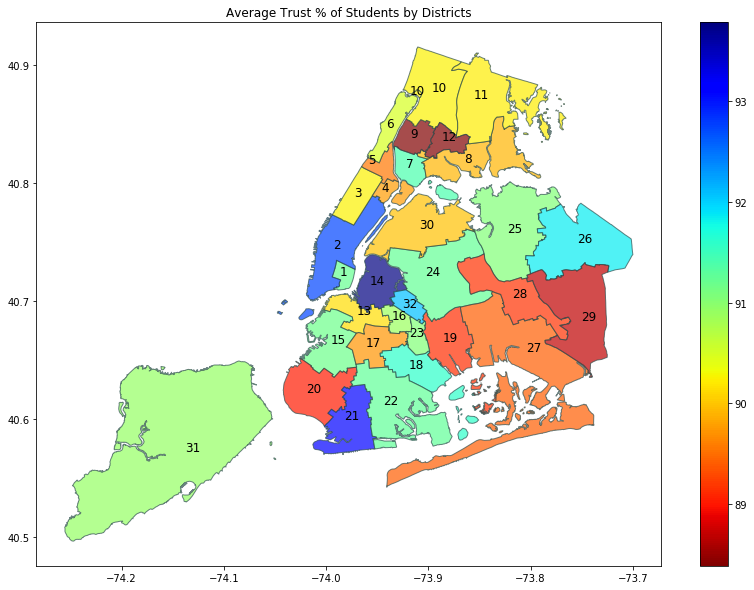

In [26]:
fig,ax = plt.subplots(1, figsize=(14,10))

districts['coords'] = districts['geometry'].apply(lambda x: x.representative_point().coords[:])
districts['coords'] = [coords[0] for coords in districts['coords']]
districts.plot(column='Trust %',ax=ax, legend=True,
               cmap='jet_r', alpha=0.7, edgecolor='darkslategray')
for idx, row in districts.iterrows():
    plt.annotate(s=row['SchoolDist'], xy=row['coords'],
                 horizontalalignment='center', fontsize=12)
    
plt.title('Average Trust % of Students by Districts');

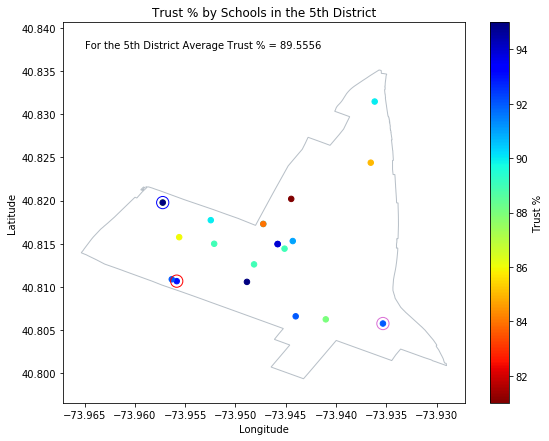

In [27]:
fig = plt.figure(figsize=(9,7)) 
ax = fig.gca() 
ax.add_patch(PolygonPatch(districts.geometry[4],
                          fc='none',ec='slategray', 
                          alpha=0.5,zorder=2 ))
d5_shsat_2016.plot(kind='scatter',x='Longitude',y='Latitude',ax=ax,
                   s=30,c='Trust %',cmap=cm.jet_r)
ax.scatter(d5_shsat_2016['Longitude'][[7,13,16]],
           d5_shsat_2016['Latitude'][[7,13,16]],
           s=150,facecolors='none',
           edgecolors=['red','blue','orchid'])
ax.text(-73.965,40.8377,
        'For the 5th District Average Trust % = '+\
        str(round(districts['Trust %'][4],4)))
plt.title('Trust % by Schools in the 5th District');

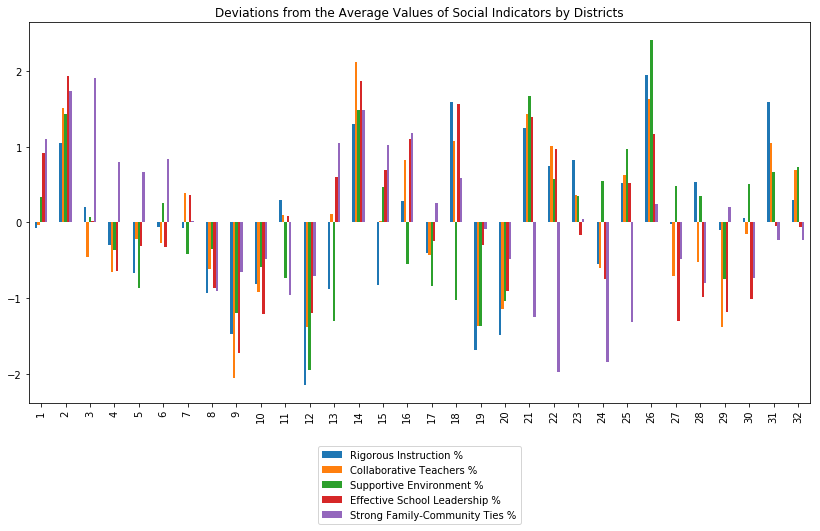

In [28]:
fig = plt.figure(figsize=(14,7)) 
ax = fig.gca() 
se_districts = districts[districts.columns[16:21]].drop([10])
norm_se_districts=(se_districts-se_districts.mean())/se_districts.std()
norm_se_districts.plot.bar(ax=ax)
plt.title('Deviations from the Average Values of Social Indicators by Districts')
ax.legend(loc=9, bbox_to_anchor=(0.5,-0.1))
ax.set_xticks(list(range(0,32)))
ax.set_xticklabels(list(range(1,33)));

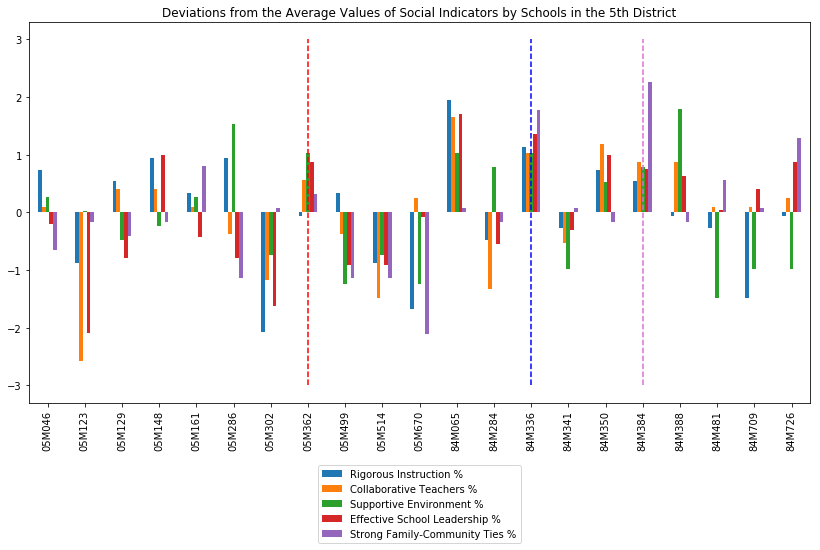

In [107]:
fig = plt.figure(figsize=(14,7)) 
ax = fig.gca() 
se_d5_shsat_2016 = d5_shsat_2016[d5_shsat_2016.columns[13:18]]
norm_se_d5_shsat_2016=(se_d5_shsat_2016-se_d5_shsat_2016.mean())/se_d5_shsat_2016.std()
norm_se_d5_shsat_2016.plot.bar(ax=ax)
plt.title('Deviations from the Average Values of Social Indicators by Schools in the 5th District')
ax.vlines(7,-3,3,linestyle="--",color='red') 
ax.vlines(13,-3,3,linestyle="--",color='blue')
ax.vlines(16,-3,3,linestyle="--",color='orchid')
ax.set_xticks(list(range(0,21)))
ax.set_xticklabels(list(d5_shsat_2016['Location Code']),
                   rotation=90)
ax.legend(loc=9, bbox_to_anchor=(0.5,-0.15));

Consideration of deviations from the mean values in the region makes data visualization more objective. 

Regions of the country have quite different opportunities in organizing the social environment. Large megacities, of course, have great potential in this case.

By the way, three leaders in the 5th District have very good levels for this type of indicators.

## &#x1F310; &nbsp; Safety Data Visualization

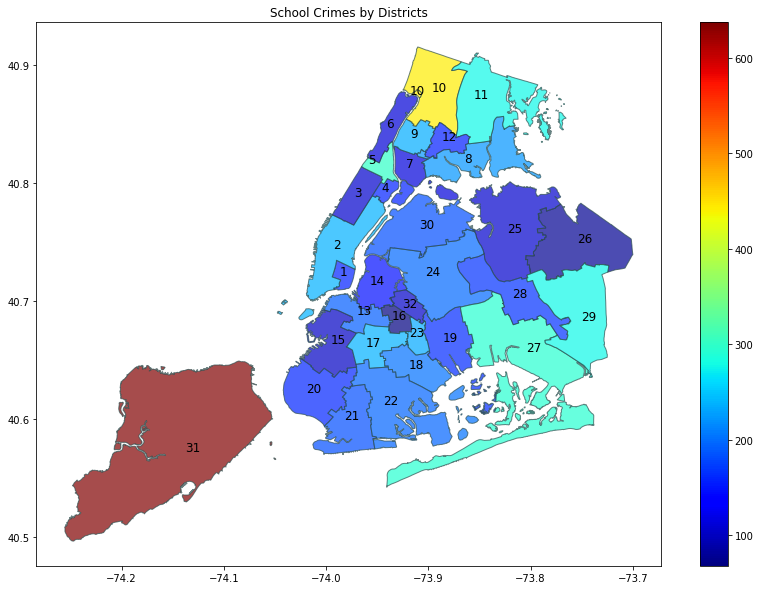

In [30]:
fig,ax = plt.subplots(1, figsize=(14,10))

districts_safety['coords'] = districts_safety['geometry'].apply(lambda x: x.representative_point().coords[:])
districts_safety['coords'] = [coords[0] for coords in districts_safety['coords']]
districts_safety['Crime N'] = districts_safety[crime_list].sum(axis=1)

districts_safety.plot(column='Crime N',ax=ax, legend=True,
                      cmap='jet', alpha=0.7, edgecolor='darkslategray')
for idx, row in districts.iterrows():
    plt.annotate(s=row['SchoolDist'], xy=row['coords'],
                 horizontalalignment='center', fontsize=12)
    
plt.title('School Crimes by Districts');

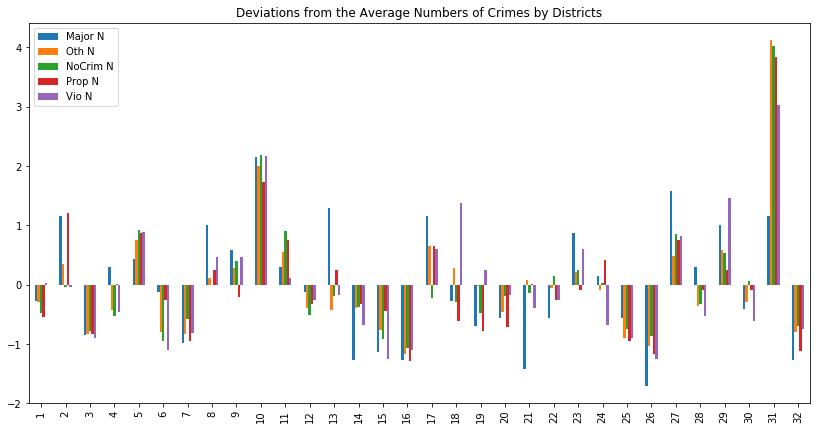

In [31]:
fig = plt.figure(figsize=(14,7)) 
ax = fig.gca() 
ss_districts = districts_safety[crime_list].drop([10])
norm_ss_districts=(ss_districts-ss_districts.mean())/ss_districts.std()
norm_ss_districts.plot.bar(ax=ax)
plt.title('Deviations from the Average Numbers of Crimes by Districts')
#ax.legend(loc=9, bbox_to_anchor=(0.5,-0.1))
ax.set_xticks(list(range(0,32)))
ax.set_xticklabels(list(range(1,33)));

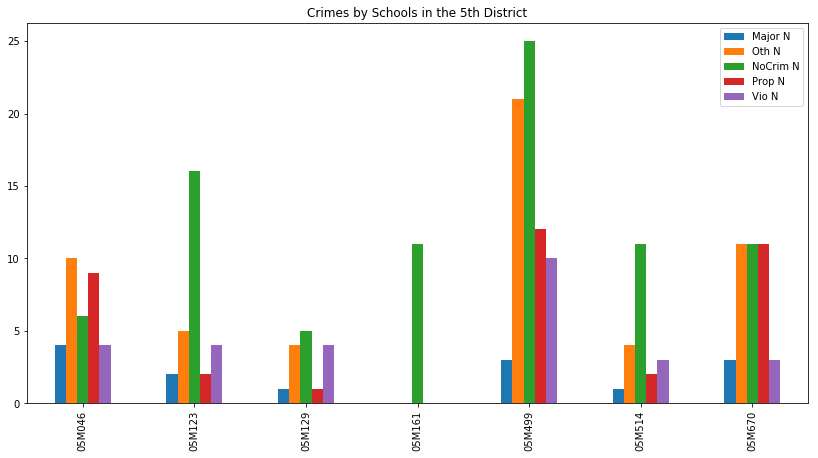

In [32]:
fig = plt.figure(figsize=(14,7)) 
ax = fig.gca() 
d5shsat_safety[crime_list].plot.bar(ax=ax)
plt.title('Crimes by Schools in the 5th District')
ax.set_xticklabels(list(d5shsat_safety['Location Code']));

About three leaders among schools in the 5th District there is no information about the crimes committed. Perhaps they had not happened at all.

## &#x1F310; &nbsp; Additional Education Data Visualization

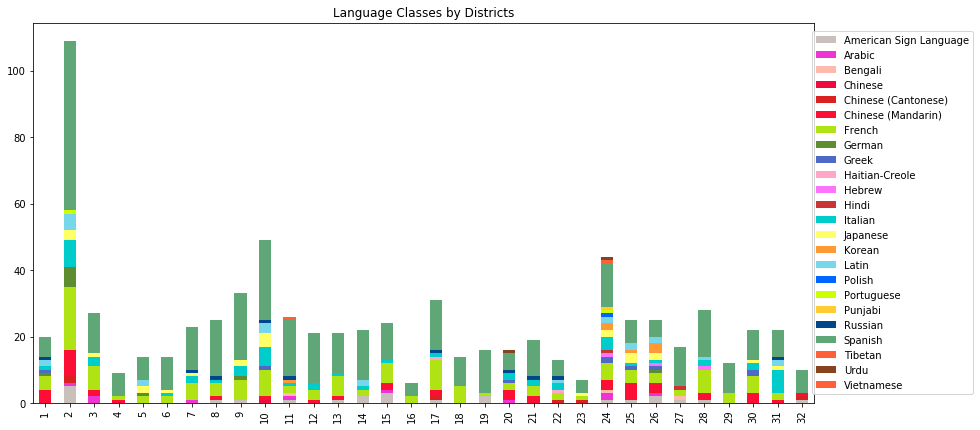

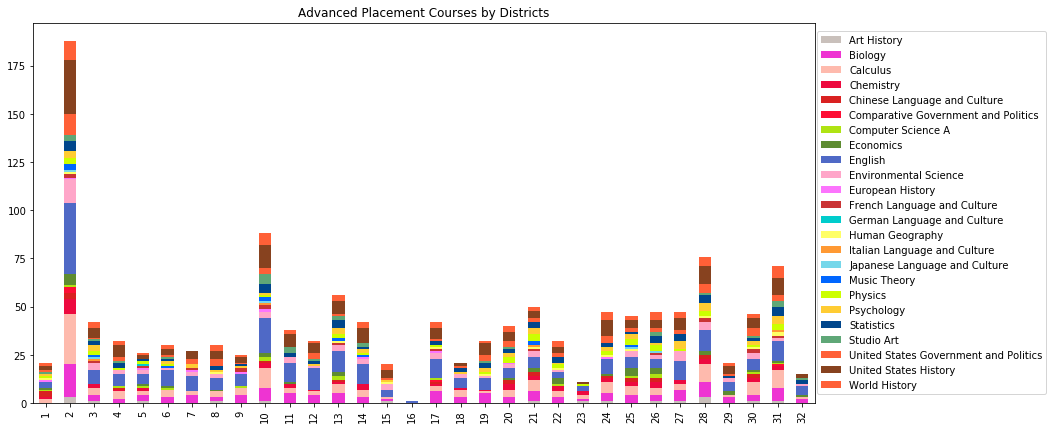

In [33]:
fig = plt.figure(figsize=(14,7)) 
ax = fig.gca()

hsl_colors = ['#C9C0BB','#EE34D2','#FEBAAD','#ED0A3F',
              '#D92121','#FD0E35','#AFE313','#5E8C31',
              '#4F69C6','#FFA6C9','#FC74FD','#CA3435',
              '#00CCCC','#FFFF66','#FF9933','#76D7EA',
              '#0066FF','#CCFF00','#FFCC33','#00468C',
              '#5FA777','#FF6037','#87421F','#FF6037']

districts_hsl.iloc[:,1:].plot.bar(ax=ax,stacked=True,color=hsl_colors)
plt.title('Language Classes by Districts')
ax.set_xticks(list(range(0,32)))
ax.set_xticklabels(list(range(1,33)))
ax.legend(loc=10, bbox_to_anchor=(1.1,0.5));

fig = plt.figure(figsize=(14,7)) 
ax = fig.gca()

districts_hsa.iloc[:,1:].plot.bar(ax=ax,stacked=True,color=hsl_colors)
plt.title('Advanced Placement Courses by Districts')
ax.set_xticks(list(range(0,32)))
ax.set_xticklabels(list(range(1,33)))
ax.legend(loc=10, bbox_to_anchor=(1.15,0.5));

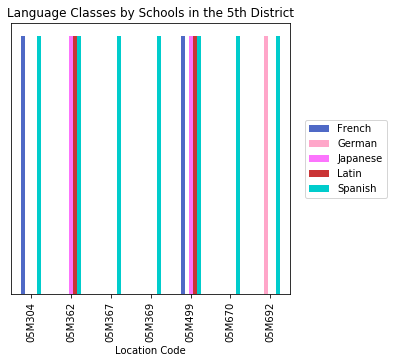

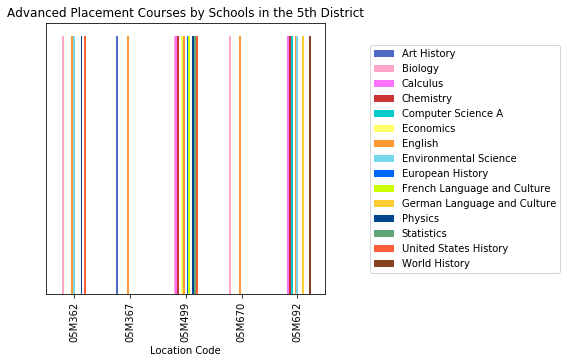

In [34]:
hsl5d = hsl[hsl['District']==5]
hsl5d = hsl5d.loc[:, (hsl5d != 0).any(axis=0)]\
.set_index(hsl5d['Location Code'])

fig = plt.figure(figsize=(5,5)) 
ax = fig.gca()
hsl5d.iloc[:,1:-1].plot.bar(ax=ax,color=hsl_colors[8:])
plt.title('Language Classes by Schools in the 5th District')
ax.legend(loc=10, bbox_to_anchor=(1.2,0.5))
ax.set_yticks([])

hsa5d = hsa[hsa['District']==5]
hsa5d = hsa5d.loc[:, (hsa5d != 0).any(axis=0)]\
.set_index(hsa5d['Location Code'])

fig = plt.figure(figsize=(5,5)) 
ax = fig.gca()
hsa5d.iloc[:,1:-1].plot.bar(ax=ax,color=hsl_colors[8:])
plt.title('Advanced Placement Courses by Schools in the 5th District')
ax.legend(loc=10, bbox_to_anchor=(1.5,0.5))
ax.set_yticks([]);

## &#x1F310; &nbsp; Sports Activity Data Visualization

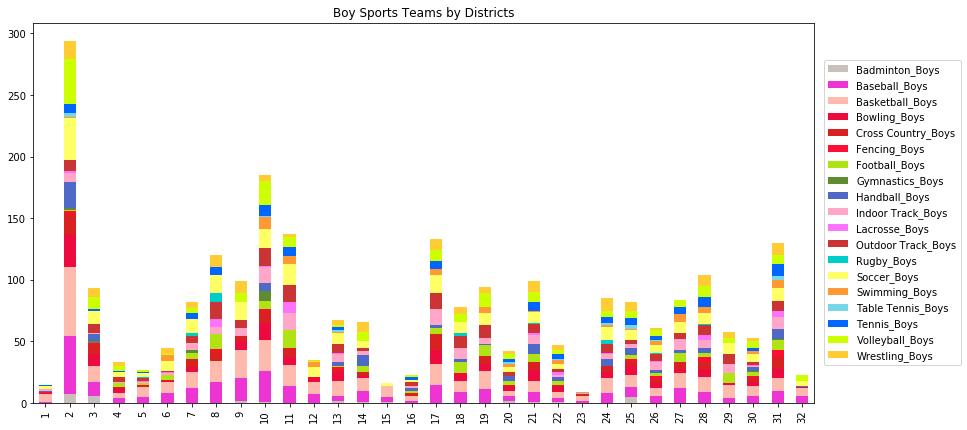

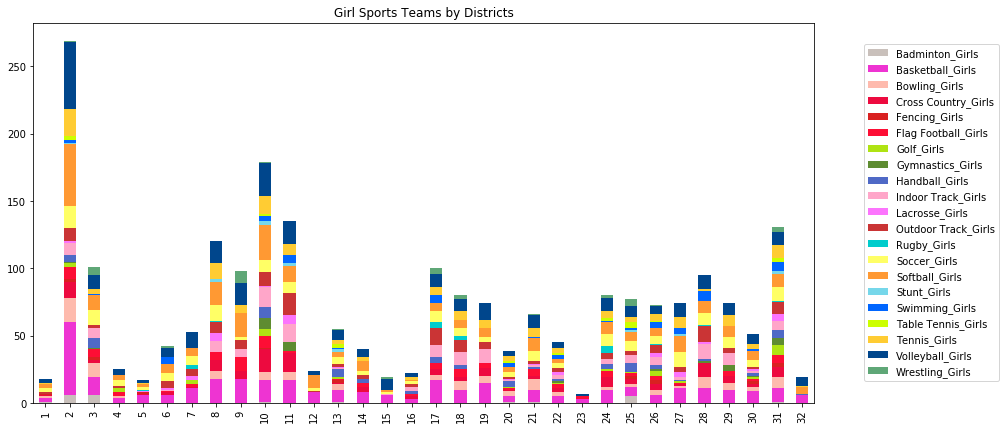

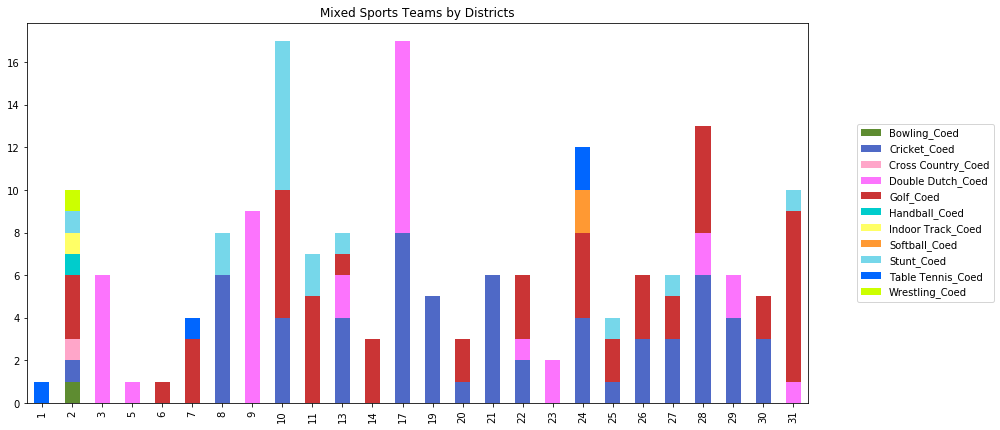

In [91]:
fig = plt.figure(figsize=(14,7)) 
ax = fig.gca()

districts_hss_boy.iloc[:,1:].plot.bar(ax=ax,stacked=True,color=hsl_colors)
plt.title('Boy Sports Teams by Districts')
ax.set_xticks(list(range(0,32)))
ax.set_xticklabels(list(range(1,33)))
ax.legend(loc=10, bbox_to_anchor=(1.1,0.5))

fig = plt.figure(figsize=(14,7)) 
ax = fig.gca()

districts_hss_girl.iloc[:,1:].plot.bar(ax=ax,stacked=True,color=hsl_colors)
plt.title('Girl Sports Teams by Districts')
ax.set_xticks(list(range(0,32)))
ax.set_xticklabels(list(range(1,33)))
ax.legend(loc=10, bbox_to_anchor=(1.15,0.5))

fig = plt.figure(figsize=(14,7)) 
ax = fig.gca()

districts_hss_coed.iloc[:,1:].plot.bar(ax=ax,stacked=True,color=hsl_colors[7:])
plt.title('Mixed Sports Teams by Districts')
ax.set_xticks(list(range(0,26)))
ax.set_xticklabels(list(districts_hss_coed['District']))
ax.legend(loc=10, bbox_to_anchor=(1.15,0.5));

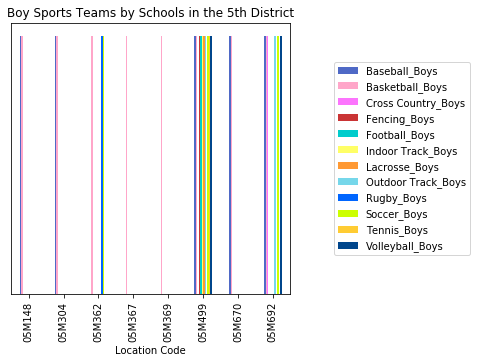

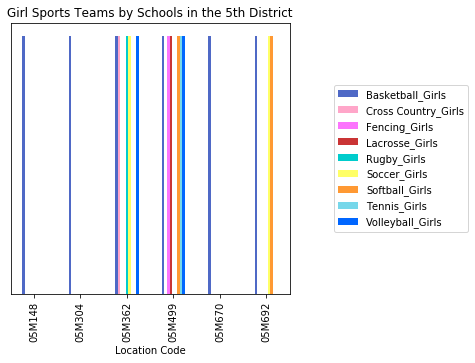

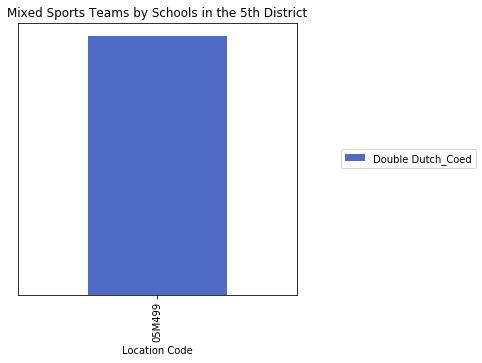

In [94]:
hss_boy5d = hss_boy[hss_boy['District']==5]
hss_boy5d = hss_boy5d.loc[:, (hss_boy5d != 0).any(axis=0)]\
.set_index(hss_boy5d['Location Code'])

fig = plt.figure(figsize=(5,5)) 
ax = fig.gca()
hss_boy5d.iloc[:,1:-1].plot.bar(ax=ax,color=hsl_colors[8:])
plt.title('Boy Sports Teams by Schools in the 5th District')
ax.legend(loc=10, bbox_to_anchor=(1.4,0.5))
ax.set_yticks([])

hss_girl5d = hss_girl[hss_girl['District']==5]
hss_girl5d = hss_girl5d.loc[:, (hss_girl5d != 0).any(axis=0)]\
.set_index(hss_girl5d['Location Code'])

fig = plt.figure(figsize=(5,5)) 
ax = fig.gca()
hss_girl5d.iloc[:,1:-1].plot.bar(ax=ax,color=hsl_colors[8:])
plt.title('Girl Sports Teams by Schools in the 5th District')
ax.legend(loc=10, bbox_to_anchor=(1.4,0.5))
ax.set_yticks([]);

hss_coed5d = hss_coed[hss_coed['District']==5]
hss_coed5d = hss_coed5d.loc[:, (hss_coed5d != 0).any(axis=0)]\
.set_index(hss_coed5d['Location Code'])

fig = plt.figure(figsize=(5,5)) 
ax = fig.gca()
hss_coed5d.iloc[:,1:-1].plot.bar(ax=ax,color=hsl_colors[8:])
plt.title('Mixed Sports Teams by Schools in the 5th District')
ax.legend(loc=10, bbox_to_anchor=(1.4,0.5))
ax.set_yticks([]);

Visualization allows immediately to allocate districts and schools paying attention to language training, additional courses, and sports activity.

One of the leaders (05M362) in terms of academic indicators in the 5th District is on the graph in the last two sections.

Information about the other two leaders is missing in the downloaded files, but it can easily be found on the pages of these schools on the Internet.

## &#x1F310; &nbsp; Let's Go Ahead
It' s time to move to the next step.

PASSNYC. Summary